In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib

In [3]:
# %matplotlib widget
%matplotlib inline

### os 
import os 
import sys

### datetimes 
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from calendar import month_name, month_abbr
import dateparser

### scipy 
import numpy as np 
import pandas as pd
import xarray as xr
from cartopy import crs as ccrs

### plotting 
from matplotlib import pyplot as plt
import palettable

In [4]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

### import local functions for the downloading of the C3S forecasts 

In [5]:
sys.path.append('../..')

In [6]:
from ICU_Water_Watch import geo, C3S, domains, plot, utils

In [7]:
domains.domains

{'Tropical_Pacific': [140, 220, -25, 25],
 'SW_Pacific': [172.5, 190, -22.5, -12],
 'Fiji': [175, 183, -21, -15],
 'NZ': [161, 181, -50, -30],
 'Pacific': [140, 240, -50, 25],
 'C3S_download': [100, 240, -50, 30],
 'Water_Watch': [125, 240, -35, 25]}

In [8]:
domain = domains.domains['Water_Watch']

### EEZ shapes 

In [9]:
dpath_shapes = HOME.joinpath('operational/ICU/development/hotspots/data/shapefiles')

In [10]:
EEZs, merged_EEZs = geo.get_EEZs(dpath_shapes)

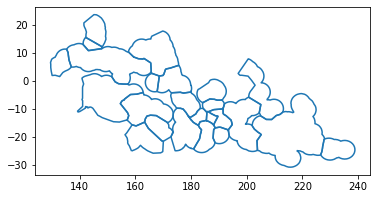

In [11]:
EEZs.boundary.plot(); 

### year and month (initial month of the forecast)

In [12]:
date = 'last month'

In [13]:
year = dateparser.parse(date).year

In [14]:
month = dateparser.parse(date).month

In [15]:
print(f"{year} - {month}")

2021 - 11


### read the probabilistic forecasts from the GCMs now 

### provider 

In [16]:
provider = 'CDS'

#### list of GCMs to inlude 

In [17]:
list_GCMs = ['ECMWF','UKMO','METEO_FRANCE','CMCC','DWD', 'NCEP', 'JMA', 'ECCC_CanCM4i', 'ECCC_GEM_NEMO']

#### period (`monthly` or `seasonal`)

In [18]:
# period = 'monthly'
period = 'seasonal'

In [19]:
if period == 'seasonal': 
    nsteps = 3
    first_step = 3
elif period == 'monthly': 
    nsteps = 5
    first_step = 1

### choose the step here 

In [20]:
step = 1

In [21]:
step = step + first_step - 1

In [22]:
step

3

#### quantiles (`tercile`, `decile`, `percentile`, with the latest including categories defined by quantile 0.02 (2%) and then 0.05 to 0.95 with 0.05 increment)

In [23]:
quantile = 'decile'

### variable 

In [24]:
varname = 'precip'

### paths to the realtime forecasts

In [25]:
dpath_forecasts = CWD.parents[1].joinpath("outputs/C3S")

In [26]:
lfiles = list(dpath_forecasts.glob(f"{period}_{quantile}s_probabilities_from_{year}-{str(month).zfill(2)}_*.netcdf"))

### checks the files names 

In [27]:
[f.name for f in lfiles]

['seasonal_deciles_probabilities_from_2021-11_UKMO.netcdf',
 'seasonal_deciles_probabilities_from_2021-11_ECMWF.netcdf',
 'seasonal_deciles_probabilities_from_2021-11_JMA.netcdf',
 'seasonal_deciles_probabilities_from_2021-11_ECCC_CanCM4i.netcdf',
 'seasonal_deciles_probabilities_from_2021-11_METEO_FRANCE.netcdf',
 'seasonal_deciles_probabilities_from_2021-11_CMCC.netcdf',
 'seasonal_deciles_probabilities_from_2021-11_ECCC_GEM_NEMO.netcdf',
 'seasonal_deciles_probabilities_from_2021-11_DWD.netcdf',
 'seasonal_deciles_probabilities_from_2021-11_NCEP.netcdf']

### open the multiple files dataset, concatenate along the "GCM" dimension 

In [28]:
probs = xr.open_mfdataset(lfiles, concat_dim='GCM', combine='nested', engine='netcdf4') 

In [29]:
probs

,Array,Chunk
Bytes,20.19 MiB,2.24 MiB
Shape,"(9, 10, 1, 3, 81, 121)","(1, 10, 1, 3, 81, 121)"
Count,27 Tasks,9 Chunks
Type,float64,numpy.ndarray


### interpolate

In [30]:
probs = utils.interp(probs, interp_factor=6)

In [31]:
probs

,Array,Chunk
Bytes,726.82 MiB,80.76 MiB
Shape,"(9, 10, 1, 3, 486, 726)","(1, 10, 1, 3, 486, 726)"
Count,71 Tasks,9 Chunks
Type,float64,numpy.ndarray


In [32]:
probs = probs.mean('GCM')

### make sure the probabilities sum to 100 over the decile dimension 

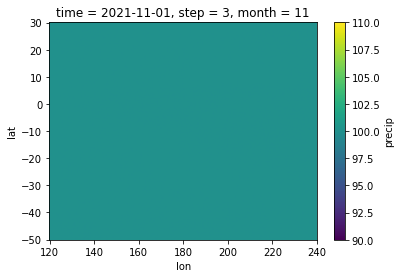

In [33]:
probs.sum('decile').squeeze().sel(step=3)['precip'].plot()

### Now calculates the cumulative probabilities over the decile dimension 

In [34]:
cum_probs = probs.cumsum('decile', keep_attrs=True)

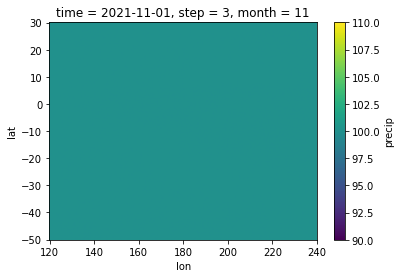

In [35]:
cum_probs.isel(decile=-1).sel(step=step).squeeze()['precip'].plot()

### recode the decile values, so they go from 1 to 10 instead of 0 to 9 

In [36]:
cum_probs.decile

<xarray.DataArray 'decile' (decile: 10)>
array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Coordinates:
    month    int64 11
Dimensions without coordinates: decile

In [37]:
cum_probs['decile'] = cum_probs['decile'] + 1

In [38]:
cum_probs.decile

<xarray.DataArray 'decile' (decile: 10)>
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])
Coordinates:
    month    int64 11
  * decile   (decile) int64 1 2 3 4 5 6 7 8 9 10

#### selects probabilities greater or equal than 50% 

In [39]:
cum_probs = cum_probs.where(cum_probs['precip'] >= 50)

### quick plot of the minimum decile value for the cumulative decile probabilities reaching 50% 

Text(0.5, 1.0, '')

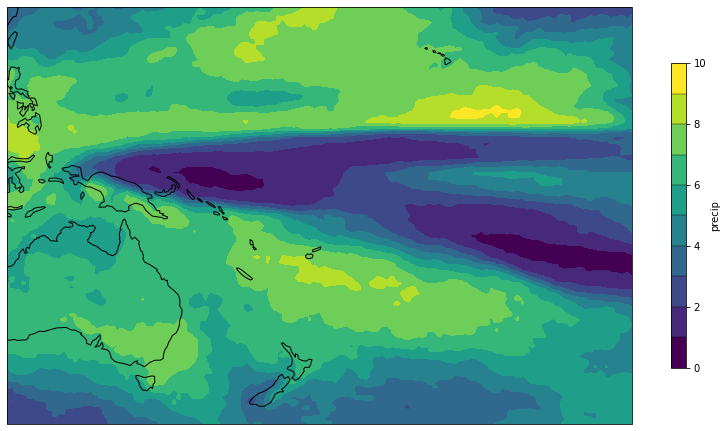

In [40]:
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)), figsize=(14,8))

cum_probs.idxmin('decile').squeeze().sel(step=step)['precip'].plot.contourf(ax=ax, levels=np.arange(0, 11), transform=ccrs.PlateCarree(), \
                                                                   cbar_kwargs={'shrink':0.7, 'boundaries':np.arange(11), 'drawedges':True})
ax.coastlines()

ax.set_title('')

### Now starts the prototype plotting 

In [41]:
thresholds = np.arange(0.5, 10.5 + 1, 1)

In [42]:
thresholds

array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5])

In [43]:
ticks_marks = np.diff(np.array(thresholds)) / 2.

ticks = [thresholds[i] + ticks_marks[i] for i in range(len(thresholds) - 1)]

In [44]:
ticks

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

In [45]:
hexes = ['#003c30', '#01665e', '#35978f', '#80cdc1', '#c7eae5', '#f6e8c3', '#dfc27d', '#bf812d', '#8c510a', '#543005']

In [46]:
hexes.reverse()

In [47]:
# cbar_ticklabels = ['>90%', '80-90%', '70-80%', '60-70%', '50-60%', '40-50%', '30-40%', '20-30%', '10-20%', '< 10%']
cbar_ticklabels = ['>90th', '80-90th', '70-80th', '60-70th', '50-60th', '40-50th', '30-40th', '20-30th', '10-20th', '< 10th']

In [48]:
cbar_ticklabels.reverse()

In [49]:
cbar_ticklabels

['< 10th',
 '10-20th',
 '20-30th',
 '30-40th',
 '40-50th',
 '50-60th',
 '60-70th',
 '70-80th',
 '80-90th',
 '>90th']

In [50]:
import matplotlib

In [51]:
cmap = matplotlib.colors.ListedColormap(hexes, name='decile')

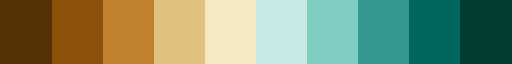

In [52]:
cmap

In [53]:
decile_map = cum_probs.idxmin('decile').squeeze().sel(step=step)

In [54]:
merged_EEZs

,index,geometry
0,EEZ,"POLYGON ((188.63281 -22.23893, 188.62887 -22.2..."


In [55]:
decile_map = geo.make_mask_from_gpd(decile_map, merged_EEZs, subset=False, insert=True)

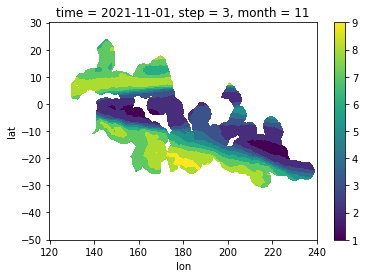

In [56]:
(decile_map['precip'] * decile_map['mask']).plot()

In [57]:
month_name = list(month_name)

In [58]:
month_name += month_name[1:]

In [59]:
if period == 'monthly': 
    label_period = month_name[month + step]
elif period == 'seasonal': 
    label_period = month_name[month + step - 2] + " - " + month_name[month + step]

In [60]:
step

3

In [61]:
label_period

'December - February'

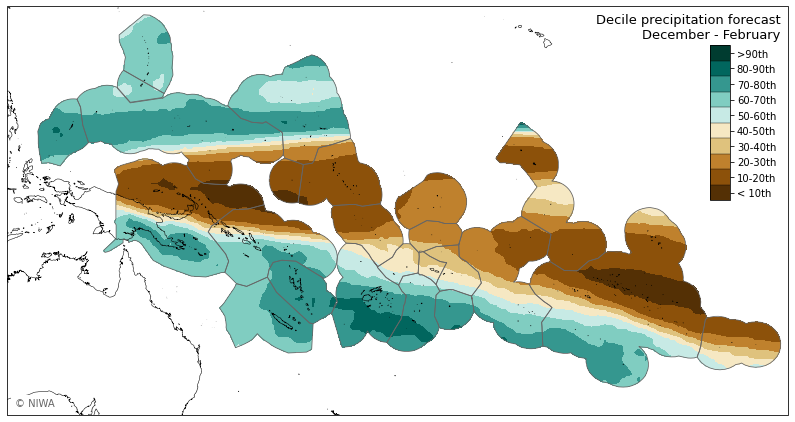

In [85]:
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)), figsize=(14,8))

ff = (decile_map['precip'] * decile_map['mask']).plot.contourf(ax=ax, levels=thresholds, cmap=cmap, transform=ccrs.PlateCarree(), add_colorbar=False)

ax.coastlines(resolution='10m', lw=0.5)

ax.set_title('')

cbar_kwargs={'shrink':0.5, 'pad':0.01, 'extend':'neither', 'drawedges':True, 'ticks':ticks, 'aspect':15}

cbar_ax = ax.axes.inset_axes([0.9, 0.525, 0.025, 0.38])

cb = plt.colorbar(ff, cax=cbar_ax, **cbar_kwargs)

cb.ax.minorticks_off()

cbar_ax.set_yticklabels(cbar_ticklabels)

plot.add_geom(ax, geoms=EEZs)

title = f"Decile precipitation forecast\n{label_period}"

ax.text(0.99, 0.95, title, fontsize=13, fontdict={'color':'k'}, bbox=dict(facecolor='w', edgecolor='w'), horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)

ax.text(0.01, 0.02, u'\u00A9'+" NIWA", transform=ax.transAxes, bbox=dict(facecolor='w', edgecolor='w'), fontdict=dict(color='0.4'))

# ax.text(0.99, 0.02, "(first decile value where cumulative probability reaches 50%)",transform=ax.transAxes, horizontalalignment='right')

ax.set_extent(domain, crs = ccrs.PlateCarree())

In [86]:
domain

[125, 240, -35, 25]

In [87]:
f.savefig(f'/home/nicolasf/Desktop/decile_forecast_prototype_{period}_{year}_{month:02d}_init_{label_period.replace(" - ","_")}.png', dpi=200, facecolor='w', bbox_inches='tight')

In [88]:
fpath = pathlib.Path('/home/nicolasf/operational/ICU_Web/C3S/')

In [90]:
f.savefig(fpath.joinpath(f'decile_forecast_prototype_{period}_{year}_{month:02d}_init_{label_period.replace(" - ","_")}.png'), dpi=200, facecolor='w', bbox_inches='tight')

In [65]:
probs

<xarray.Dataset>
Dimensions:  (decile: 10, time: 1, step: 3, lat: 486, lon: 726)
Coordinates:
  * time     (time) datetime64[ns] 2021-11-01
  * step     (step) int64 3 4 5
    month    int64 11
  * decile   (decile) int64 1 2 3 4 5 6 7 8 9 10
  * lon      (lon) float64 120.0 120.2 120.3 120.5 ... 239.5 239.7 239.8 240.0
  * lat      (lat) float64 -50.0 -49.84 -49.67 -49.51 ... 29.51 29.67 29.84 30.0
Data variables:
    precip   (decile, time, step, lat, lon) float64 dask.array<chunksize=(10, 1, 3, 486, 726), meta=np.ndarray>

### create station heatmap 

In [66]:
station_name = 'Nadi'
lon = 177.4356
lat = -17.7765

In [67]:
probs_station = probs.sel(lat=lat, lon=lon, method='nearest')

In [68]:
probs_station_df = probs_station.squeeze()[['precip']].to_dataframe()['precip']

In [69]:
probs_station_df = probs_station_df.unstack()

In [70]:
probs_station_df

step,3,4,5
decile,,,
1,0.000000,0.000000,0.934539
2,0.033166,1.117186,2.359248
3,1.739544,1.990731,3.826027
4,2.573454,3.806523,5.375483
5,3.760615,7.933154,6.477885
6,11.231841,10.246743,9.240611
7,14.714272,14.486587,15.815778
8,18.570918,17.196105,16.840239
9,22.272890,17.257151,15.683548


In [73]:
if period == 'seasonal': 
    n_steps = 3
elif period == 'monthly': 
    n_steps = 5

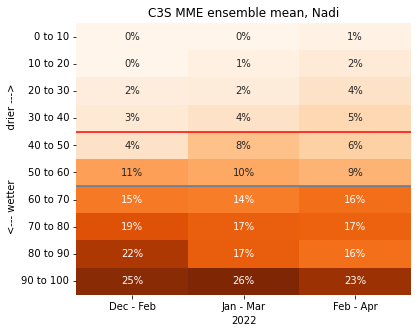

In [75]:
f, ax = plot.plot_heatmap(probs_station_df, period=period, n_steps=n_steps, year=2022, cmap='Oranges_r', title=f'C3S MME ensemble mean, Nadi', cumsum=False, start_month=month + 1)

In [ ]:
f.savefig(f'/home/nicolasf/Desktop/{station_name}_{period}_from_{year}_{month}.png', dpi=200, bbox_inches='tight', facecolor='w')